# Free GPU memory

In [79]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Libraries

In [82]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE

# Demo train data

In [83]:
import skimage
from skimage.io import imshow, imread
from skimage.transform import resize
import os
import numpy as np
path = r'F:\rzbz\Leuk study re-designed\ALLIDB-2\High imbalance\Train - 1 to 100 ratio\all'
all_list = os.listdir(path)

train_data = np.zeros((len(all_list), 256, 256, 3), dtype=np.uint8)

index = 0
for x in range(len(all_list)):
    img = imread(os.path.join(path, all_list[x]))
    img = resize(img, (256,256,3), preserve_range=True,  mode='constant')
    train_data[index] = img
    index+=1
print(train_data.shape)
print(type(train_data))

(1, 256, 256, 3)
<class 'numpy.ndarray'>


# Demo convert to tf.data

In [84]:
import tensorflow as tf
train_all = tf.data.Dataset.from_tensor_slices((train_data))
train_all

<TensorSliceDataset shapes: (256, 256, 3), types: tf.uint8>

# Train data

In [85]:
import skimage
from skimage.io import imshow, imread
import os
import numpy as np
path = r'F:\rzbz\Leuk study re-designed\ALLIDB-2\High imbalance\Train - 1 to 100 ratio\hem'
hem_list = os.listdir(path)

train_data = np.zeros((len(hem_list), 256, 256, 3), dtype=np.uint8)

index = 0
for x in range(len(hem_list)):
    img = imread(os.path.join(path, hem_list[x]))
    img = resize(img, (256,256,3), preserve_range=True,  mode='constant')
    train_data[index] = img
    index+=1
print(train_data.shape)
print(type(train_data))


(100, 256, 256, 3)
<class 'numpy.ndarray'>


# Convert to tf.data

In [86]:
import tensorflow as tf
train_hem = tf.data.Dataset.from_tensor_slices((train_data))
train_hem

<TensorSliceDataset shapes: (256, 256, 3), types: tf.uint8>

# Params

In [87]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH =  256
IMG_HEIGHT = 256

# Pre-processing

In [88]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [89]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [90]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [91]:
def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [92]:
def preprocess_image_test(image):
  image = normalize(image)
  return image

In [93]:
train_all = train_all.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_hem = train_hem.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)


# Sanity check

In [94]:
train_hem

<BatchDataset shapes: (None, 256, 256, 3), types: tf.float32>

In [95]:
sample_all = next(iter(train_all))
sample_hem = next(iter(train_hem))

<class 'tensorflow.python.framework.ops.EagerTensor'>
Before slicing:  (1, 256, 256, 3)
After slicing:  (256, 256, 3)
[0.20784312 0.2117647  0.21568626 0.21960783 0.2235294  0.22745097
 0.23137254 0.2352941  0.23921567 0.24313724 0.24705881 0.2509804
 0.25490198 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982
 0.2784314  0.28235295 0.28627452 0.2901961  0.29411766 0.29803923
 0.3019608  0.30588236 0.30980393 0.3137255  0.31764707 0.32156864
 0.3254902  0.32941177 0.33333334 0.3372549  0.34117648 0.34509805
 0.34901962 0.3529412  0.35686275 0.36078432 0.3647059  0.36862746
 0.37254903 0.3764706  0.38039216 0.38431373 0.3882353  0.39215687
 0.39607844 0.4        0.40392157 0.40784314 0.4117647  0.41568628
 0.41960785 0.42352942 0.42745098 0.43137255 0.43529412 0.4392157
 0.44313726 0.44705883 0.4509804  0.45490196 0.45882353 0.4627451
 0.46666667 0.47058824 0.4745098  0.47843137 0.48235294 0.4862745
 0.49019608 0.49411765 0.49803922 0.5019608  0.5058824  0.50980395
 0.5137255  0.5

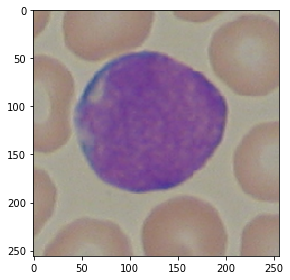

In [96]:
import numpy as np
import skimage
from skimage.io import imshow, imread
print(type(sample_all))
img = sample_all.numpy()
print('Before slicing: ', img.shape)
img = img[0,:,:,:]
img = img * 0.5 + 0.5
print('After slicing: ', img.shape)
print(np.unique(img))
imshow(img)

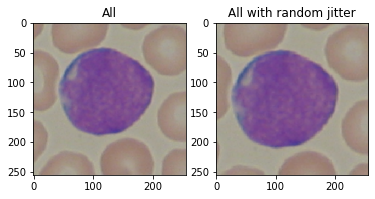

In [97]:
plt.subplot(121)
plt.title('All')
plt.imshow(sample_all[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('All with random jitter')
plt.imshow(random_jitter(sample_all[0]) * 0.5 + 0.5)

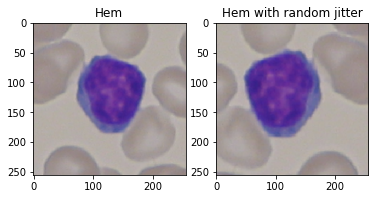

In [98]:
plt.subplot(121)
plt.title('Hem')
plt.imshow(sample_hem[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Hem with random jitter')
plt.imshow(random_jitter(sample_hem[0]) * 0.5 + 0.5)

# Get pix2pix

In [99]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

# Pre-trained pix2pix result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


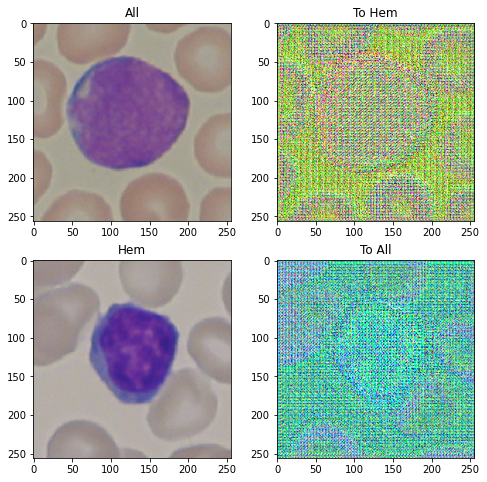

In [100]:
to_hem = generator_g(sample_all)
to_all = generator_f(sample_hem)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_all, to_hem, sample_hem, to_all]
title = ['All', 'To Hem', 'Hem', 'To All']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

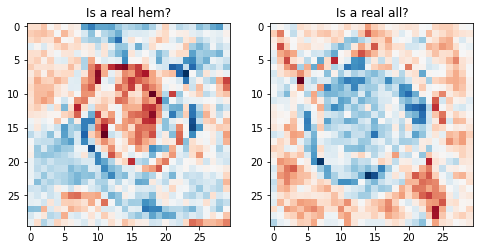

In [101]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real hem?')
plt.imshow(discriminator_y(sample_hem)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real all?')
plt.imshow(discriminator_x(sample_all)[0, ..., -1], cmap='RdBu_r')

plt.show()

# Loss

In [102]:
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [103]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [104]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [105]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [106]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

# Optimizers

In [107]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Checkpoint

In [108]:
checkpoint_path = r"F:\rzbz\Leuk study re-designed\ALLIDB-2\High imbalance\chkpnt"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

# Train functions

In [109]:
EPOCHS = 50


def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [110]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

# Train

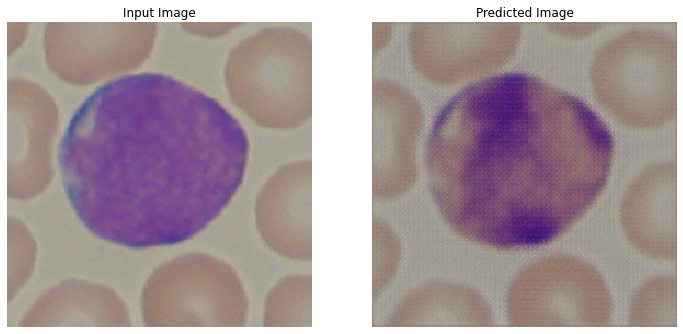

Saving checkpoint for epoch 50 at F:\rzbz\Leuk study re-designed\ALLIDB-2\High imbalance\chkpnt\ckpt-10
Time taken for epoch 50 is 14.797118663787842 sec



In [111]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_all, train_hem)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_all)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

# Prediction

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<dtype: 'float32'>


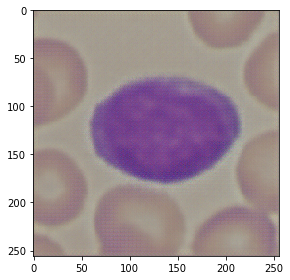

In [114]:

import skimage
from skimage.io import imread, imshow, imsave

index=0
# Run the trained model on the test dataset
for inp in train_hem.take(100):
   im = generate_images(generator_f, inp)

   im = im.numpy()

   im = im * 0.5 + 0.5

   imshow(im)

   path = 'F:/rzbz/Leuk study re-designed/ALLIDB-2/High imbalance/Train - 1 to 100 ratio/Cyclegan Oversample/all' + '/' + hem_list[index][:-4] + '_syn.bmp'
   imsave(path, im)
   index+=1